<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210912_%E7%89%B9%E5%BE%B4%E9%87%8FE_%E9%80%A3%E7%B6%9A%E5%87%A6%E7%90%86_%E3%83%A2%E3%83%87%E3%83%AB%E6%A4%9C%E8%A8%8E_OneClassSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['data',
 '210904_学習データの読み込み.ipynb',
 '210906_EDA_train.ipynb',
 '210908_EDA_test.ipynb',
 '210908_テストデータの読み込み_作成.ipynb',
 '210909_特徴量エンジニアリング.ipynb',
 '210912_特徴量E_連続処理_モデル検討.ipynb']

# 単ファイル読み込み～波形特徴量化処理

In [3]:
DIR_DATA_TRAIN = os.path.join(DIR, 'data', 'Train_Unit_20210903')
DIR_DATA_TEST = os.path.join(DIR, 'data', 'Test_Unit_20210903')

In [4]:
#例ファイルの読み込み
folder = 'Train_Unit_1'
C = 'Charge'
exp_files = glob.glob(os.path.join(DIR_DATA_TRAIN, folder, C, '*.csv'))
exp_file = [s for s in exp_files if 'File_1.csv' in s]

In [5]:
exp = exp_file[0]

In [6]:
tmp_df = pd.read_csv(exp, encoding='utf-8')

In [7]:
#カラム名変更前後の辞書
col_list = {'Time (s)' : 'Time',
            'Voltage Measured (V)' : 'VM',
            'Voltage Charge (V)' : 'VC',
            'Current Measured (Amps)' : 'CM', 
            'Current Charge (Amps)' : 'CC',
            'Temperature (degree C)': 'Temp', 
            'unit' : 'unit_name', 
            'charge_mode' : 'mode', 
            'Cycle_num' : 'Cycle',
            'Voltage Load (V)' : 'VL',
            'Current Load (Amps)' : 'CL'
}

In [8]:
tmp_df = tmp_df.rename(columns=col_list)
tmp_df.head()

,Time,VM,VC,CM,CC,Temp,Unnamed: 6
0,0.000,3.3251,0.003,0.000302,-0.002,29.342,NaN
1,2.516,3.0020,1.414,-3.362000,-3.370,29.336,NaN
2,5.500,3.4346,4.142,1.508700,1.498,29.335,NaN
3,8.391,3.4549,4.180,1.510000,1.498,29.342,NaN
4,11.266,3.4688,4.196,1.508700,1.498,29.331,NaN


In [9]:
#一連のデータ処理
def get_some_values(file_path):
  #ファイルパスから、ユニット名を取得。
  dirname = os.path.dirname(file_path)
  dirname_split = dirname.split('/')#区切り文字'/'で分割
  unit = dirname_split[-2]
  charge_mode = dirname_split[-1]
  #ファイルパスから、サイクル数を取得。
  basename = os.path.basename(file_path)
  basename_split = basename.split('_')[4]#区切り文字'_'で分割
  cycle_num = basename_split.split('.')[0]
  return unit, charge_mode, cycle_num

In [10]:
unit, charge_mode, cycle_num = get_some_values(exp)
tmp_df[['unit', 'charge_mode', 'Cycle_num']] = unit, charge_mode, cycle_num
tmp_df.head()

,Time,VM,VC,CM,CC,Temp,Unnamed: 6,unit,charge_mode,Cycle_num
0,0.000,3.3251,0.003,0.000302,-0.002,29.342,NaN,Train_Unit_1,Charge,1
1,2.516,3.0020,1.414,-3.362000,-3.370,29.336,NaN,Train_Unit_1,Charge,1
2,5.500,3.4346,4.142,1.508700,1.498,29.335,NaN,Train_Unit_1,Charge,1
3,8.391,3.4549,4.180,1.510000,1.498,29.342,NaN,Train_Unit_1,Charge,1
4,11.266,3.4688,4.196,1.508700,1.498,29.331,NaN,Train_Unit_1,Charge,1


In [11]:
def featured_c_vm(df):
  #LAG=5が0.001未満が続くところを、飽和領域とみなす。
  p_c_vm = df.loc[:, 'VM'][df.loc[:, 'VM'].diff(5) < 0.001]
  #飽和領域のなかで、最初の点を点P_C_VMとする。
  p_c_vm = p_c_vm.reset_index(inplace=False)
  p_c_vm = p_c_vm['index'].iloc[0]
  #充電VMの特徴量は、点P_C_VMにおける時間
  feature_c_vm = df['Time'].loc[p_c_vm]
  return feature_c_vm

def featured_c_cm(df):
  #飽和領域からの立ち下がり点(LAG=5の勾配が最小となる点)を点P_C_CMとする。
  p_c_cm = np.gradient(df.loc[:, 'CM'].diff(5)[10:]).argmin()
  #充電CMの特徴量は、点P_C_CMにおける時間
  feature_c_cm = df['Time'].loc[p_c_cm]
  return feature_c_cm

def featured_c_vc(df):
  #VCが最大値を示す点を、点P_C_VCとする。
  p_c_vc = df.VC.argmax()
  #充電VCの特徴量は、点P_C_VCにおける時間
  feature_c_vc = df['Time'].loc[p_c_vc]
  return feature_c_vc

def featured_d_vm(df):
  #VMが最小値を示す点を、点P_D_VMとする。
  p_d_vm = df.VM.argmin()
  #放電VMの特徴量は、点P_D_VMにおける時間
  feature_d_vm = df['Time'].loc[p_d_vm]
  return feature_d_vm

def featured_d_vl(df):
  #VLの最大値点以降の領域において、最小値を示す点を、点P_D_VLとする。
  VL_max = df.VL.argmax()
  p_d_vl = df.VL[VL_max: ].argmin()
  #放電VLの特徴量は、点P_D_VLにおける時間
  feature_d_vl = df['Time'].loc[p_d_vl]
  return feature_d_vl

In [12]:
feature_c_vm, feature_c_cm, feature_c_vc = featured_c_vm(tmp_df), featured_c_cm(tmp_df), featured_c_vc(tmp_df)
feature_c_vm, feature_c_cm, feature_c_vc

(3422.5, 3207.4, 3241.8)

In [13]:
#特徴量のデータフレームの作成(充電)
df_exp = pd.DataFrame([{'unit':unit,
                       'charge_mode' : charge_mode,
                       'Cycle_num' : cycle_num,
                       'feature_c_vm' : feature_c_vm,
                       'feature_c_cm' : feature_c_cm,
                       'feature_c_vc' : feature_c_vc}])

In [14]:
df_exp

,unit,charge_mode,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc
0,Train_Unit_1,Charge,1,3422.5,3207.4,3241.8


# 連続処理

充電

In [147]:
%time
C = 'Charge'
#C = 'Discharge'

df_list = []
for folder in tqdm(os.listdir(DIR_DATA_TRAIN)[:3]):
  files = glob.glob(os.path.join(DIR_DATA_TRAIN, folder, C, '*.csv'))
  df_list_0 = []
  for file in files:
    tmp_df = pd.read_csv(file, encoding='utf-8')
    tmp_df = tmp_df.rename(columns=col_list)
    #ユニット名、充・放電モード、サイクル数の取得
    unit, charge_mode, cycle_num = get_some_values(file)
    #特徴量のデータフレームの作成(充電)
    df_exp = pd.DataFrame([{'unit':unit,
                       'charge_mode' : charge_mode,
                       'Cycle_num' : int(cycle_num),
                       'feature_c_vm' : featured_c_vm(tmp_df),
                       'feature_c_cm' : featured_c_cm(tmp_df),
                       'feature_c_vc' : featured_c_vc(tmp_df)}])
    df_list_0.append(df_exp)
  df_0 = pd.concat(df_list_0)
  df_list.append(df_0)
df = pd.concat(df_list)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


In [148]:
df_processed = df.copy()

In [149]:
#ユニットとサイクルでソート。
df_processed = df_processed.sort_values(['unit', 'Cycle_num'])

In [150]:
#インデックスの振り直し
df_processed = df_processed.reset_index(drop=True)

In [151]:
df_processed.head()

,unit,charge_mode,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc
0,Train_Unit_1,Charge,1,3422.5,3207.4,3241.8
1,Train_Unit_1,Charge,2,3431.6,3181.8,3262.3
2,Train_Unit_1,Charge,3,3409.1,9692.7,3229.2
3,Train_Unit_1,Charge,4,3407.7,3160.2,3228.2
4,Train_Unit_1,Charge,5,3409.6,3172.4,3217.9


In [20]:
df.shape

(261, 6)

In [21]:
DIR_DATA_TRAIN = os.path.join(DIR, 'data', 'Train_Unit_20210903')
for folder in os.listdir(DIR_DATA_TRAIN)[:3]:
  for C in os.listdir(os.path.join(DIR_DATA_TRAIN, folder)):
    files = glob.glob(os.path.join(DIR_DATA_TRAIN, folder, C, '*.csv'))
    print(f'{folder}','--',f'{C}のサイクル数：',len(files))

Train_Unit_3 -- Chargeのサイクル数： 97
Train_Unit_3 -- Dischargeのサイクル数： 97
Train_Unit_2 -- Chargeのサイクル数： 40
Train_Unit_2 -- Dischargeのサイクル数： 40
Train_Unit_1 -- Chargeのサイクル数： 124
Train_Unit_1 -- Dischargeのサイクル数： 124


In [22]:
print('学習データの全ユニットのファイル数：', 97+40+124)

学習データの全ユニットのファイル数： 261


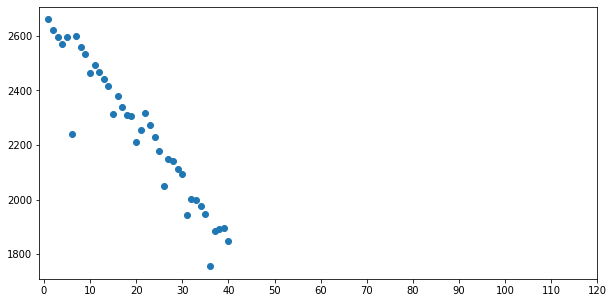

In [23]:
data = df_processed[df_processed['unit'] == 'Train_Unit_2']
fig, ax = plt.subplots()

fig.set_figwidth(10)
fig.set_figheight(5)

ax.scatter(data.Cycle_num, data.feature_c_vc)
ax.set_xticks(np.arange(0, 130, step=10))

plt.show()

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 124 to 163
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit          40 non-null     object 
 1   charge_mode   40 non-null     object 
 2   Cycle_num     40 non-null     int64  
 3   feature_c_vm  40 non-null     float64
 4   feature_c_cm  40 non-null     float64
 5   feature_c_vc  40 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 2.2+ KB


# モデル化検討

・One Class SVMによるモデリング

In [25]:
from sklearn import preprocessing
from sklearn.svm import OneClassSVM

充電_ユニット1モデル

In [52]:
col = ['feature_c_vm', 'feature_c_cm', 'feature_c_vc']
unit = 'Train_Unit_1'

In [53]:
train_df = df_processed[df_processed['unit'] == unit][col]
train_df.head()

,feature_c_vm,feature_c_cm,feature_c_vc
0,3422.5,3207.4,3241.8
1,3431.6,3181.8,3262.3
2,3409.1,9692.7,3229.2
3,3407.7,3160.2,3228.2
4,3409.6,3172.4,3217.9


In [67]:
kikan = 10

In [68]:
#学習データ(指定期間のレコードまで)
train = train_df.iloc[:kikan]
#検証データ(残り)
val = train_df.iloc[kikan:]

In [69]:
#標準化
sc = preprocessing.StandardScaler()
sc.fit(train)
train_X = sc.transform(train)
val_X = sc.transform(val)

In [70]:
#モデルの定義
model = OneClassSVM(nu=0.01)
#学習
model.fit(train_X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.01, shrinking=True, tol=0.001, verbose=False)

In [71]:
#予測
pred_train = model.predict(train_X)
pred_val = model.predict(val_X)
pred_label = np.concatenate((pred_train, pred_val))

In [72]:
#分離平面からの距離
distance_train = model.decision_function(train_X)
distance_val = model.decision_function(val_X)
pred_desicion = np.concatenate((distance_train, distance_val))

In [73]:
#データセットへの追加
train_df['pred_label'] = pred_label
train_df['pred_desicion'] = pred_desicion

In [74]:
train_df.head()

,feature_c_vm,feature_c_cm,feature_c_vc,pred_label,pred_desicion
0,3422.5,3207.4,3241.8,-1,-0.000137
1,3431.6,3181.8,3262.3,-1,-0.000297
2,3409.1,9692.7,3229.2,-1,-0.000051
3,3407.7,3160.2,3228.2,1,0.002314
4,3409.6,3172.4,3217.9,1,0.000269


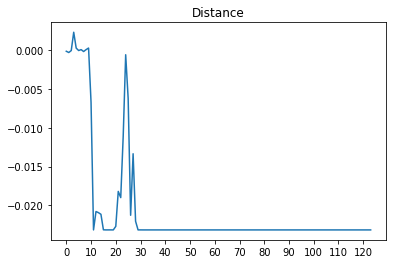

In [75]:
fig, ax = plt.subplots()

ax.plot(train_df.index, train_df['pred_desicion'], label='Distance')
ax.set_title('Distance')

ax.set_xticks(np.arange(0, 130, 10))

plt.show();

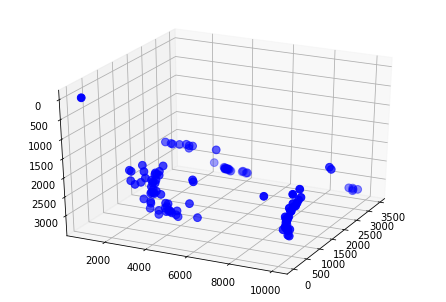

In [39]:
#SVMの結果の可視化
from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

ax = Axes3D(figure, elev=-152, azim=-26)

x1 = train_df_C_unit1['feature_c_vm']
x2 = train_df_C_unit1['feature_c_cm']
x3 = train_df_C_unit1['feature_c_vc']

ax.scatter(x1, x2, x3, c='b', s=60)

plt.show()

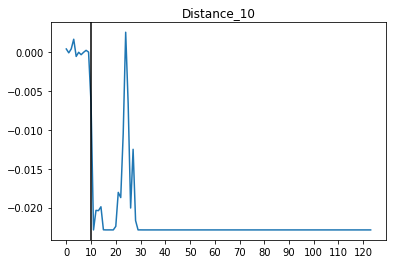

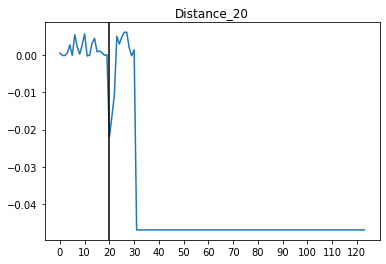

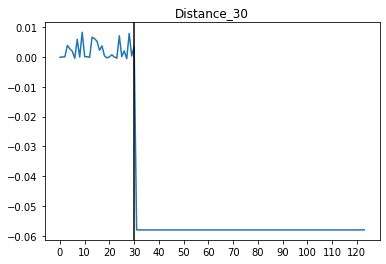

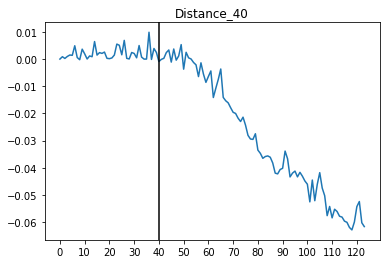

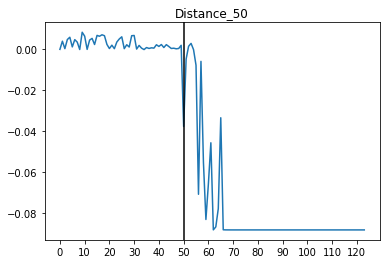

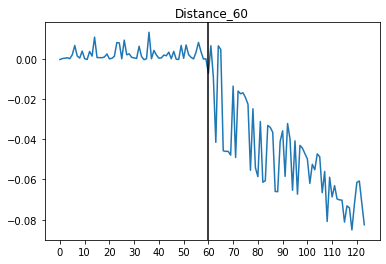

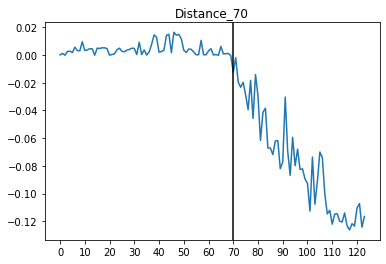

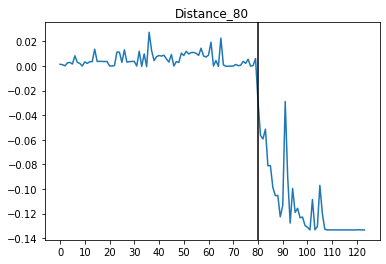

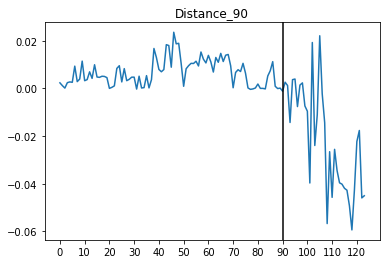

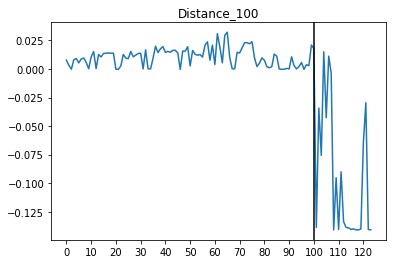

In [82]:
#一連の可視化の流れを連続処理

range = np.arange(10, 110, 10)

for kikan in range:
  #学習データ(指定期間のレコードまで)
  train = train_df.iloc[:kikan]
  #検証データ(残り)
  val = train_df.iloc[kikan:]

  #標準化
  sc = preprocessing.StandardScaler()
  sc.fit(train)
  train_X = sc.transform(train)
  val_X = sc.transform(val)

  #モデルの定義
  model = OneClassSVM(nu=0.01)
  #学習
  model.fit(train_X)

  #予測
  pred_train = model.predict(train_X)
  pred_val = model.predict(val_X)
  pred_label = np.concatenate((pred_train, pred_val))

  #分離平面からの距離
  distance_train = model.decision_function(train_X)
  distance_val = model.decision_function(val_X)
  pred_desicion = np.concatenate((distance_train, distance_val))

  #データセットへの追加
  train_df['pred_label'] = pred_label
  train_df['pred_desicion'] = pred_desicion

  fig, ax = plt.subplots()

  ax.plot(train_df.index, train_df['pred_desicion'], label='Distance')
  ax.set_title(f'Distance_{kikan}')
  ax.set_xticks(np.arange(0, 130, 10))

  plt.axvline(x=kikan, color='black')
  plt.show();

In [87]:
#関数化
def distance_plot(range, train_df, x_max):
  for kikan in range:
    #学習データ(指定期間のレコードまで)
    train = train_df.iloc[:kikan]
    #検証データ(残り)
    val = train_df.iloc[kikan:]

    #標準化
    sc = preprocessing.StandardScaler()
    sc.fit(train)
    train_X = sc.transform(train)
    val_X = sc.transform(val)

    #モデルの定義
    model = OneClassSVM(nu=0.01)
    #学習
    model.fit(train_X)

    #予測
    pred_train = model.predict(train_X)
    pred_val = model.predict(val_X)
    pred_label = np.concatenate((pred_train, pred_val))

    #分離平面からの距離
    distance_train = model.decision_function(train_X)
    distance_val = model.decision_function(val_X)
    pred_desicion = np.concatenate((distance_train, distance_val))

    #データセットへの追加
    train_df['pred_label'] = pred_label
    train_df['pred_desicion'] = pred_desicion

    fig, ax = plt.subplots()

    ax.plot(train_df.index, train_df['pred_desicion'], label='Distance')
    ax.set_title(f'Distance_{kikan}')
    ax.set_xticks(np.arange(0, x_max+10, 10))

    plt.axvline(x=kikan, color='black')
    plt.show();

充電_ユニット2モデル

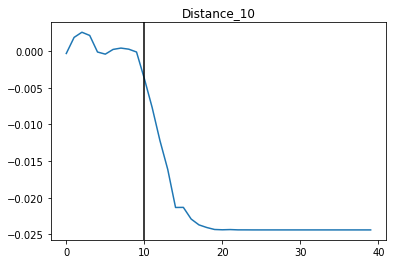

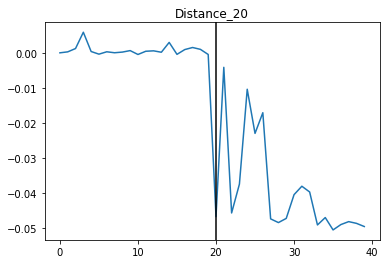

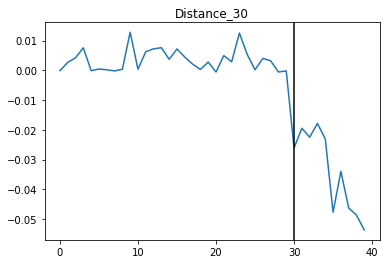

In [90]:
col = ['feature_c_vm', 'feature_c_cm', 'feature_c_vc']
unit = 'Train_Unit_2'
train_df = df_processed[df_processed['unit'] == unit][col]
train_df = train_df.reset_index()

range = np.arange(10, 40, 10)
x_max = 40

distance_plot(range, train_df, x_max)

充電_ユニット3モデル

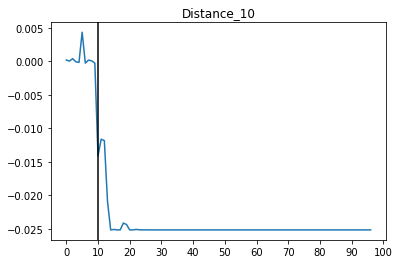

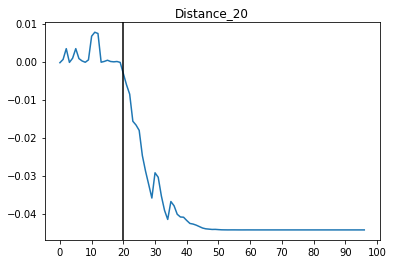

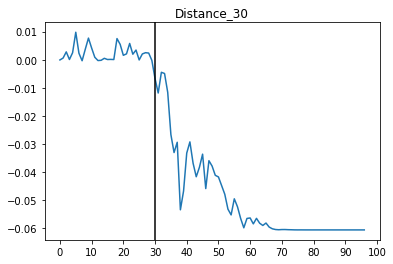

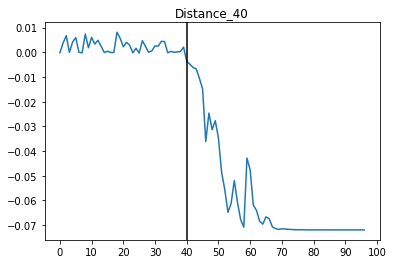

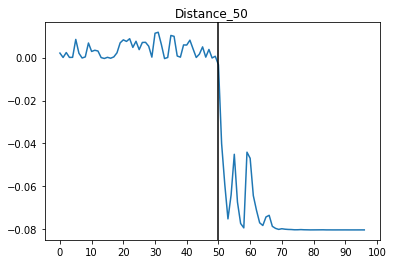

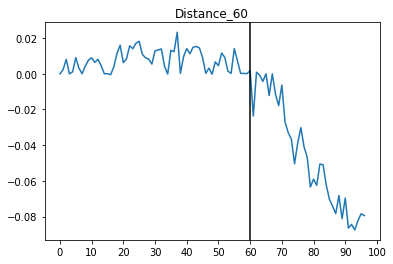

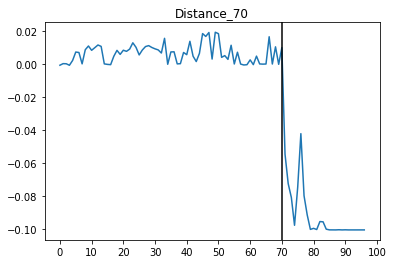

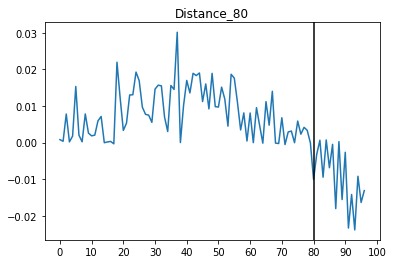

In [91]:
col = ['feature_c_vm', 'feature_c_cm', 'feature_c_vc']
unit = 'Train_Unit_3'
train_df = df_processed[df_processed['unit'] == unit][col]
train_df = train_df.reset_index()

range = np.arange(10, 90, 10)
x_max = 97

distance_plot(range, train_df, x_max)

各分離平面からの距離のプロットより、'寿命'を上手く表現できてそうな学習期間は下記。  
ユニット1(充電)モデル：学習期間 70Cycle  
ユニット2(充電)モデル：学習期間 30Cycle  
ユニット3(充電)モデル：学習期間 60Cycle  

In [ ]:
#ベスト学習モデルの定義


上記３つの学習モデルによりテストデータを推論し、寿命を予測してみる。

# テストデータ読み込み～特徴量E～推論

In [92]:
DIR_DATA_TEST = os.path.join(DIR, 'data', 'Test_Unit_20210903')
os.listdir(DIR_DATA_TEST)

['Test_Unit_1', 'Test_Unit_2', 'Test_Unit_3', 'dataset_test_all.csv']

In [152]:
%time
C = 'Charge'
#C = 'Discharge'

df_list = []
for folder in tqdm(os.listdir(DIR_DATA_TEST)[:3]):
  files = glob.glob(os.path.join(DIR_DATA_TEST, folder, C, '*.csv'))
  df_list_0 = []
  for file in files:
    tmp_df = pd.read_csv(file, encoding='utf-8')
    tmp_df = tmp_df.rename(columns=col_list)
    #ユニット名、充・放電モード、サイクル数の取得
    unit, charge_mode, cycle_num = get_some_values(file)
    #特徴量のデータフレームの作成(充電)
    df_exp = pd.DataFrame([{'unit':unit,
                       'charge_mode' : charge_mode,
                       'Cycle_num' : int(cycle_num),
                       'feature_c_vm' : featured_c_vm(tmp_df),
                       'feature_c_cm' : featured_c_cm(tmp_df),
                       'feature_c_vc' : featured_c_vc(tmp_df)}])
    df_list_0.append(df_exp)
  df_0 = pd.concat(df_list_0)
  df_list.append(df_0)
df_test = pd.concat(df_list)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


In [153]:
df_test_processed = df_test.copy()

In [154]:
#ユニットとサイクルでソート。
df_test_processed = df_test_processed.sort_values(['unit', 'Cycle_num'])

In [155]:
#インデックスの振り直し
df_test_processed = df_test_processed.reset_index(drop=True)

In [156]:
df_test_processed.head()

,unit,charge_mode,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc
0,Test_Unit_1,Charge,1,741.86,3476.3,3141.4
1,Test_Unit_1,Charge,2,849.45,3451.6,3164.0
2,Test_Unit_1,Charge,3,803.84,8280.7,3145.7
3,Test_Unit_1,Charge,4,806.83,3102.9,3123.4
4,Test_Unit_1,Charge,5,1004.50,3147.9,3163.0


In [98]:
for folder in os.listdir(DIR_DATA_TEST)[:3]:
  for C in os.listdir(os.path.join(DIR_DATA_TEST, folder)):
    files = glob.glob(os.path.join(DIR_DATA_TEST, folder, C, '*.csv'))
    print(f'{folder}','--',f'{C}のサイクル数：',len(files))

Test_Unit_1 -- Chargeのサイクル数： 70
Test_Unit_1 -- Dischargeのサイクル数： 70
Test_Unit_2 -- Chargeのサイクル数： 12
Test_Unit_2 -- Dischargeのサイクル数： 12
Test_Unit_3 -- Chargeのサイクル数： 55
Test_Unit_3 -- Dischargeのサイクル数： 55


モデル学習～推論

In [171]:
col = ['feature_c_vm', 'feature_c_cm', 'feature_c_vc']
unit_train = 'Train_Unit_1'
unit_test = 'Test_Unit_3'

train_df = df_processed[df_processed['unit'] == unit_train][col]
test_df = df_test_processed[df_test_processed['unit'] == unit_test][col]

In [172]:
#学習データ(指定期間のレコードまで)
kikan = 70
train = train_df.iloc[:kikan]
#検証データ(残り)
test = test_df

In [173]:
#標準化
sc_train = preprocessing.StandardScaler()
sc_train.fit(train)
train_X = sc_train.transform(train)

sc_test = preprocessing.StandardScaler()
sc_test.fit(test)
test_X = sc_test.transform(test)

In [174]:
#モデルの定義
model = OneClassSVM(nu=0.01)
#学習
model.fit(train_X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.01, shrinking=True, tol=0.001, verbose=False)

In [175]:
#推論
pred_test = model.predict(test_X)

#分離平面からの距離
distance_test = model.decision_function(test_X)

#データセットへの追加
test_df['pred_label'] = pred_test
test_df['pred_desicion'] = distance_test

test_df = test_df.reset_index(drop=False)

In [176]:
test_df.head()

,index,feature_c_vm,feature_c_cm,feature_c_vc,pred_label,pred_desicion
0,82,3894.3,3498.2,3596.4,-1,-0.006158
1,83,3680.8,3507.3,3604.9,-1,-0.002574
2,84,3855.0,3446.6,3570.7,-1,-0.002640
3,85,3607.4,3432.6,3544.8,1,0.005243
4,86,3609.2,3434.5,3534.8,1,0.006308


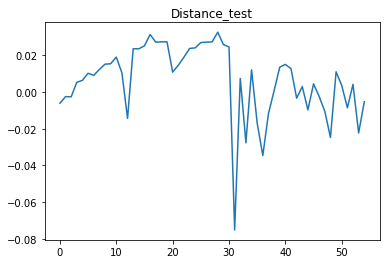

In [177]:
fig, ax = plt.subplots()

ax.plot(test_df.index, test_df['pred_desicion'], label='Distance')
ax.set_title(f'Distance_test')
#ax.set_xticks(np.arange(0, x_max+10, 10))

#plt.axvline(x=kikan, color='black')
plt.show();